<div align='center'><font size="5" color='#353B47'>Image Segmentation</font></div>
<div align='center'><font size="4" color="#353B47">Using U-Net with Keras</font></div>
<br>
<hr>

## <div id="summary">Table of contents</div>

**<font size="2"><a href="#chap1">1. Introduction</a></font>**
**<br><font size="2"><a href="#chap2">2. Load Data</a></font>**
**<br><font size="2"><a href="#chap3">3. Get Masks</a></font>**
**<br><font size="2"><a href="#chap4">4. Training Model</a></font>**
**<br><font size="2"><a href="#chap5">5. Predict and Visualize</a></font>**

# <div id="chap1">1. Introduction</div>

The u-net is convolutional network architecture for fast and precise segmentation of images. 

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.

This illustration is an example of Unet architecture but layers can have different size.

<hr>

# <div id="chap2">Load Data</div>

Libraries

In [1]:
import tensorflow as tf
import zipfile
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from unet import *
from unetpp import *
import warnings
warnings.filterwarnings('ignore')

# # Load the extension and start TensorBoard

# %load_ext tensorboard
# %tensorboard --logdir logs

Constants

In [2]:
SEED = 42
np.random.seed = SEED

UNZIP_PATH = '../input/data-science-bowl-2018/'
TRAIN_PATH = 'dataset/cell/stage1_train/'
TEST_PATH = 'dataset/cell/stage1_test/'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [3]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
# define placeholders (also used to replace NaN in images to resize by 0)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype =bool)

# <div id="chap3">Get Masks</div>

In [10]:
# Resize images and masks
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(
        img, (IMG_HEIGHT, IMG_WIDTH), 
        mode = 'constant', 
        preserve_range = True
    )
    
    X_train[n] = img # fill empty X_train with values from img 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(
            resize(
                mask_, 
                (IMG_HEIGHT, IMG_WIDTH), 
                mode = 'constant', 
                preserve_range = True
            ), 
            axis = -1
        )
        mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask
    
    
import numpy as np

# Assuming you have xtrain and ytrain datasets

# Define the directory path to save the datasets
save_directory = 'dataset/cell/saved/'
# Save xtrain
np.save(save_directory+'image.npy', X_train)
# Save ytrain
np.save(save_directory+'mask.npy', Y_train)




100%|██████████| 670/670 [05:38<00:00,  1.98it/s]


In [5]:
# test images
X_test = np.zeros(
    (
        len(test_ids), 
        IMG_HEIGHT, 
        IMG_WIDTH, 
        IMG_CHANNELS
    ), 
    dtype = np.uint8
)

sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(
        img, 
        (IMG_HEIGHT, IMG_WIDTH), 
        mode = 'constant', 
        preserve_range = True
    )
    X_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 58.41it/s]


# <div id="chap3">Export Masks if you saved dataset before </div>

In [6]:
export_directory = 'dataset/cell/saved/'
X_train = np.load(export_directory+'image.npy')
# Save ytrain
Y_train = np.load(export_directory+'mask.npy')

NameError: name 'save_directory' is not defined

# <div id="chap4">4. Training Model</div>

In [12]:
# import model
from unet import *
from unetpp import *



model = unet()



model.summary()


Model: "UNetPP"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv00_1 (Conv2D)               (None, 128, 128, 16) 448         InputLayer[0][0]                 
__________________________________________________________________________________________________
X00_ (Dropout)                  (None, 128, 128, 16) 0           conv00_1[0][0]                   
__________________________________________________________________________________________________
conv00_2 (Conv2D)               (None, 128, 128, 16) 2320        X00_[0][0]                       
_____________________________________________________________________________________________

In [13]:
# Callbacks
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
            ]

In [14]:
results = model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.1, 
    batch_size = 16, 
    epochs = 25, 
    callbacks = callbacks)

Epoch 1/25
38/38 [==============================] - 114s 3s/step - loss: 1.3474 - iou: 0.1852 - val_loss: 0.6511 - val_iou: 0.1772
Epoch 2/25
38/38 [==============================] - 111s 3s/step - loss: 0.6393 - iou: 0.1880 - val_loss: 0.6131 - val_iou: 0.1701
Epoch 3/25
38/38 [==============================] - 110s 3s/step - loss: 0.6122 - iou: 0.1801 - val_loss: 0.5865 - val_iou: 0.1635
Epoch 4/25
38/38 [==============================] - 111s 3s/step - loss: 0.5949 - iou: 0.1731 - val_loss: 0.5681 - val_iou: 0.1573
Epoch 5/25
38/38 [==============================] - 115s 3s/step - loss: 0.5839 - iou: 0.1667 - val_loss: 0.5560 - val_iou: 0.1520
Epoch 6/25
38/38 [==============================] - 112s 3s/step - loss: 0.5774 - iou: 0.1608 - val_loss: 0.5485 - val_iou: 0.1476
Epoch 7/25
38/38 [==============================] - 109s 3s/step - loss: 0.5738 - iou: 0.1567 - val_loss: 0.5436 - val_iou: 0.1441
Epoch 8/25
38/38 [==============================] - 108s 3s/step - loss: 0.5719 - i

# <div id="chap5">5. Predict and Visualize</div>

In [15]:
# Predictions
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 320ms/step


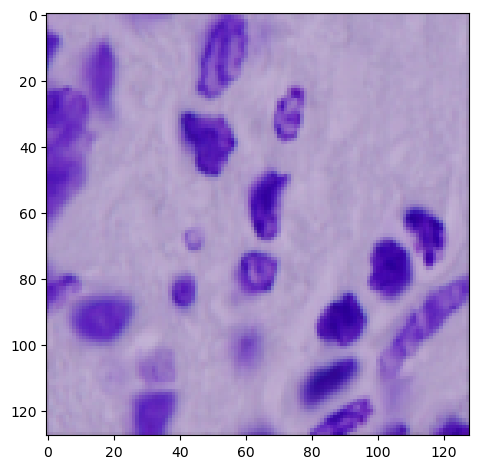

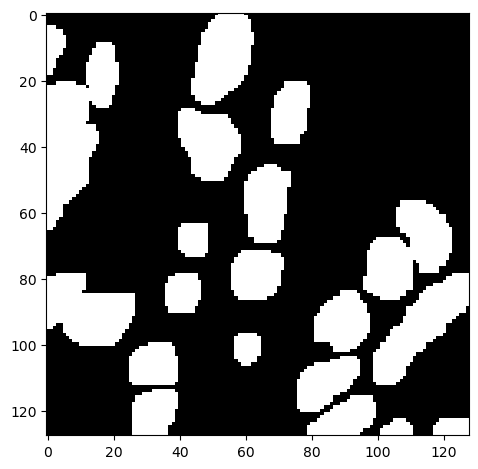

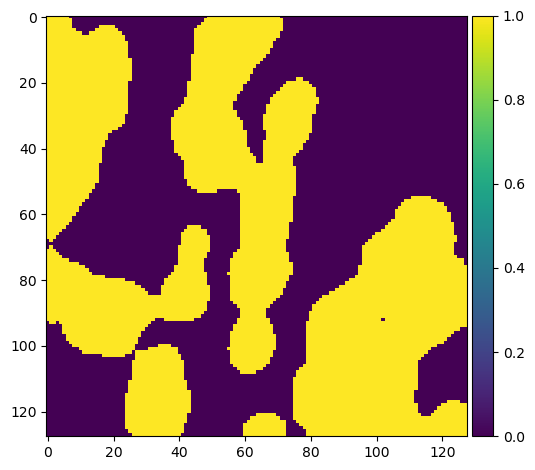

In [18]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [17]:
# Sanity check on random val samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(X_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

IndexError: index 67 is out of bounds for axis 0 with size 67

<hr>
<br>
<div align='justify'><font color="#353B47" size="4">Thank you for taking the time to read this notebook. I hope that I was able to answer your questions or your curiosity and that it was quite understandable. <u>any constructive comments are welcome</u>. They help me to progress and motivate me to share better quality content. I am above all a passionate person who tries to advance my knowledge but also that of others. If you liked it, just let me know <u>i'd appreciate.</u> </font></div>
<br>
<div align='center'><font color="#353B47" size="3">Thank you and may passion guide you.</font></div>